In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

!git clone https://github.com/SysCV/sam-hq.git
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


PyTorch version: 2.0.1+cu118
CUDA is available: True
Cloning into 'sam-hq'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 137 (delta 42), reused 113 (delta 27), pack-reused 0
Receiving objects: 100% (137/137), 32.97 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint


--2023-06-13 16:35:50--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
Resolving huggingface.co (huggingface.co)... 13.35.35.73, 13.35.35.43, 13.35.35.36, ...
Connecting to huggingface.co (huggingface.co)|13.35.35.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/e1a6c385d62bf005ded91a54d5ec55c985cfc4103ef89c08d90f39f04934c343?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_l.pth%3B+filename%3D%22sam_hq_vit_l.pth%22%3B&Expires=1686933351&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2Q5LzRlL2Q5NGUwNDk5MmFjNGUzZWE0NWZjYzFjNTIzOTc0NTQwY2RiZWYyNzRlMjk1ZDRhYWFjYzY5YjRmMTllZTYzYjcvZTFhNmMzODVkNjJiZjAwNWRlZDkxYTU0ZDVlYzU1Yzk4NWNmYzQxMDNlZjg5YzA4ZDkwZjM5ZjA0OTM0YzM0Mz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaF

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

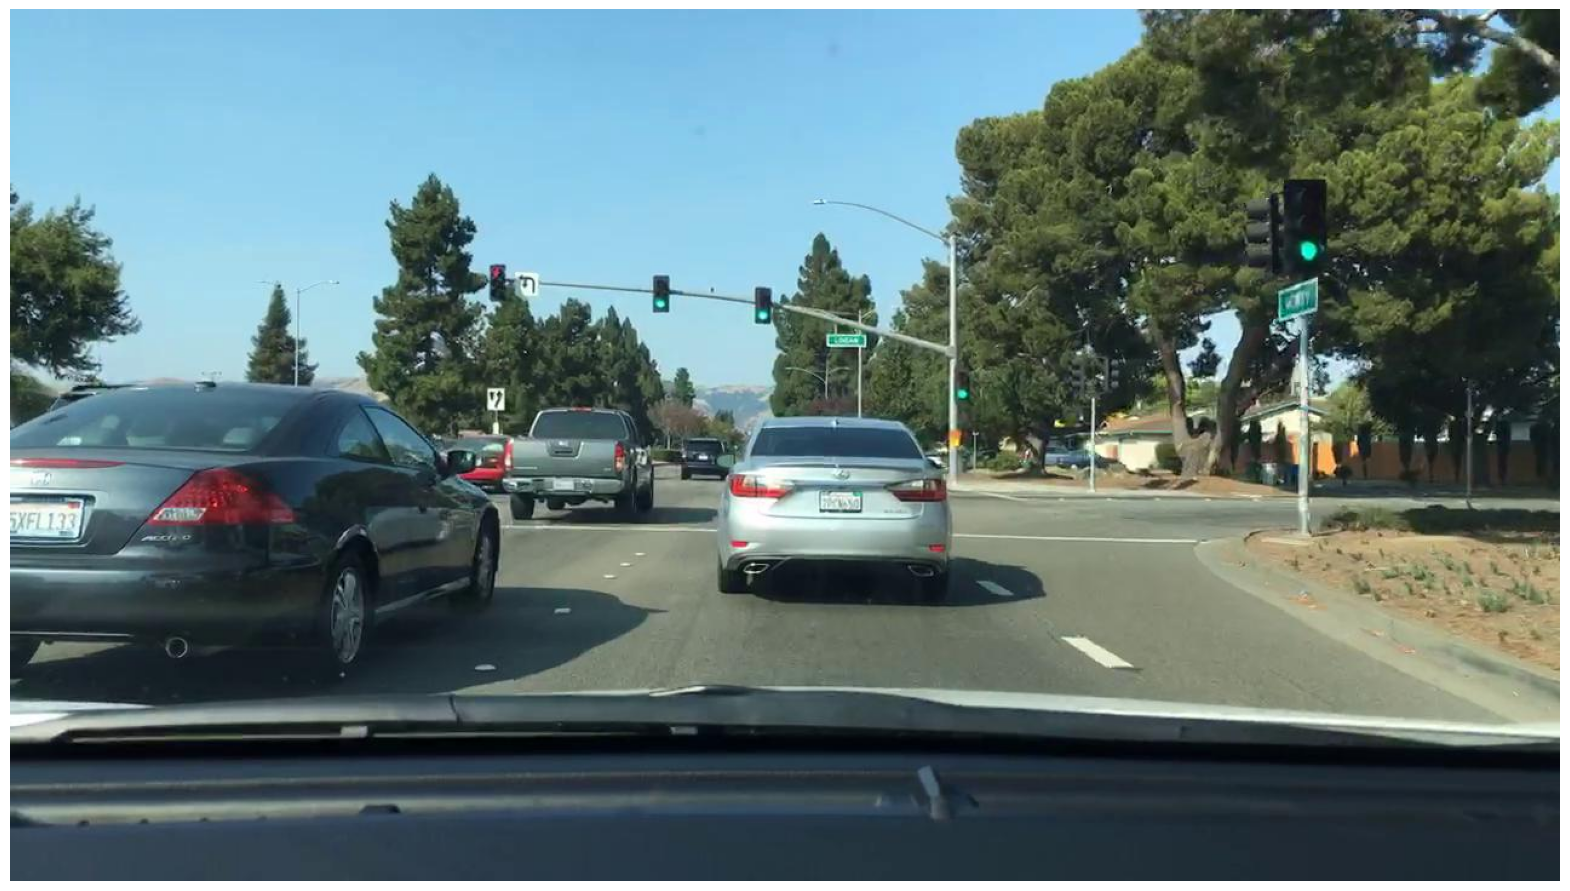

In [ ]:
image = cv2.imread('demo/input_imgs/example8.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

<All keys matched successfully>


In [ ]:
masks = mask_generator.generate(image)
len(masks)

147

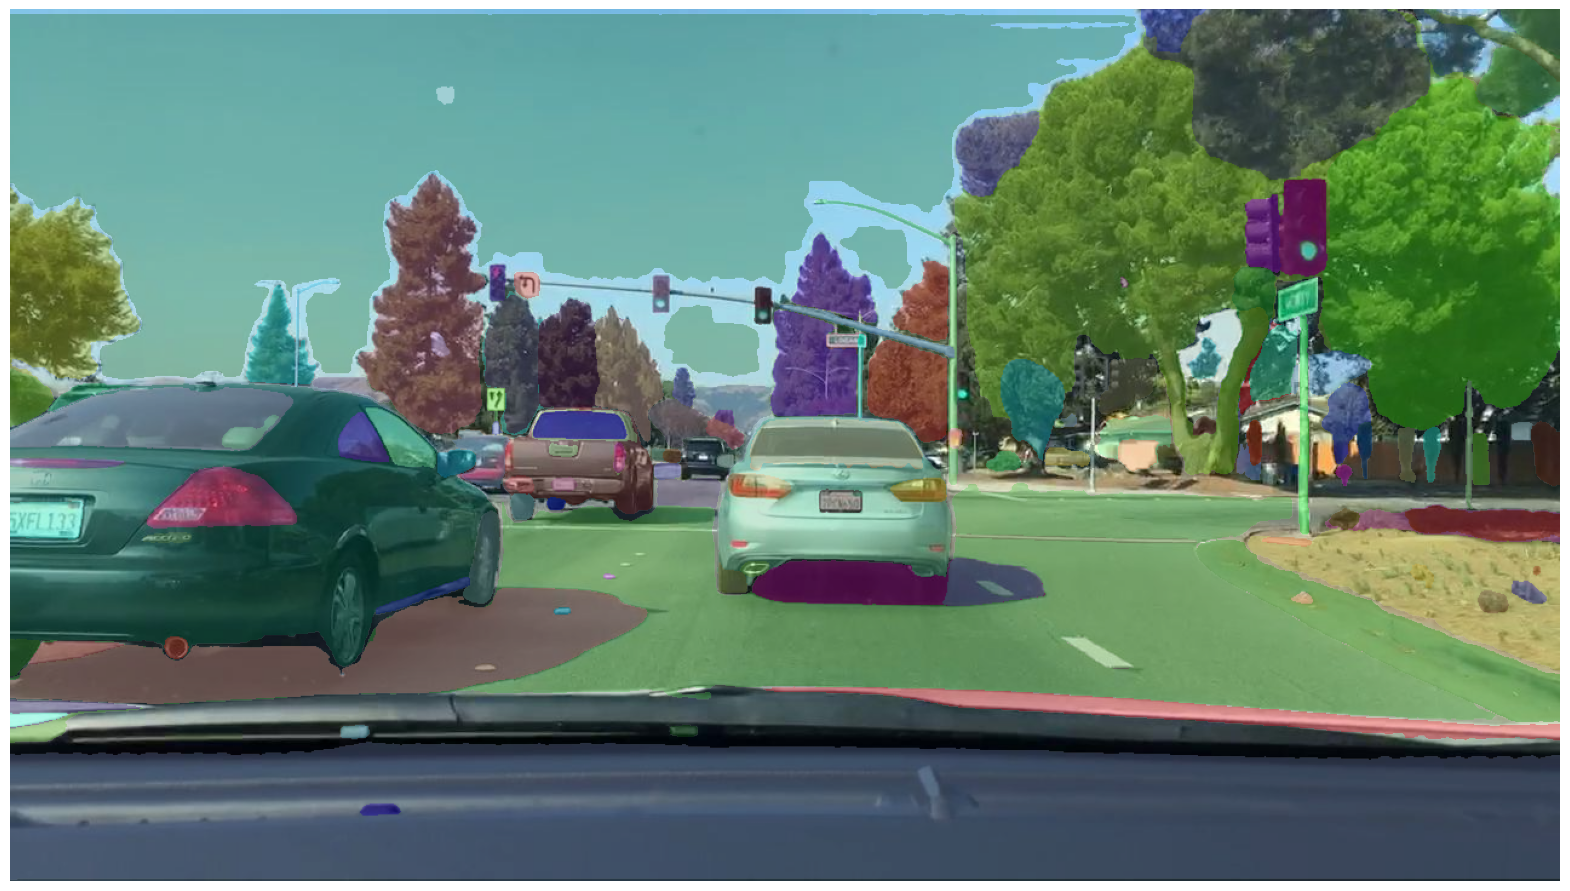

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
mask_generator2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.85,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
masks2 = mask_generator2.generate(image, multimask_output=False)
len(masks2)

136

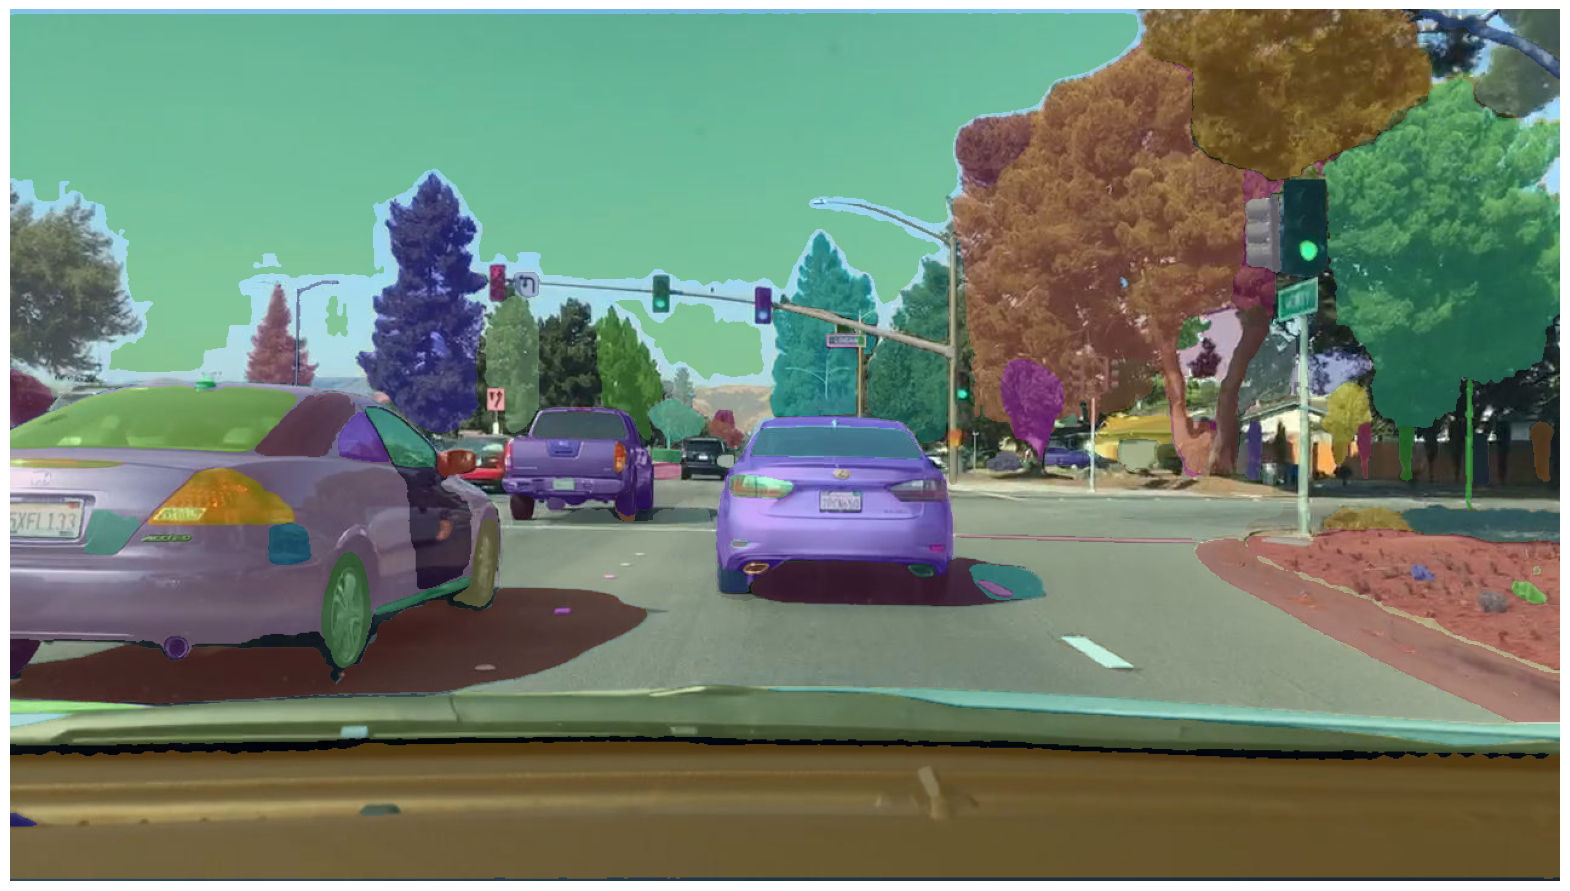

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()